In [3]:
import geopandas as gpd
import pandas as pd
import censusdata

import os 
os.chdir(r'C:\Users\nelms\Documents\Penn\CPLN-680\Permit_Metrics')

In [16]:
project_crs = 'EPSG:7132'

DATA_FOLDER = r'data'
META_FOLDER = DATA_FOLDER + r'\meta'
RAW_FOLDER = DATA_FOLDER + r'\raw'

# SF LAND BASED ON CENSUS TRACT
path = RAW_FOLDER + r'\georeference\sf_2000censustracts_nowater.geojson'
sfwater = gpd.read_file(path).to_crs(project_crs)
sfwater = sfwater[['geometry']].dissolve().explode()
sfwater['area'] = sfwater.area
sfwater = sfwater[sfwater['area'] == sfwater['area'].max()][['geometry']]
#ax = sfwater[sfwater['area'] == sfwater['area'].max()].plot(color='red', zorder=5)
#sfwater.plot(ax=ax, color='grey', zorder=4)

# RAW BLOCKS
path = RAW_FOLDER + r'\georeference\sf_2010censusblocks.geojson'
sfblock = gpd.read_file(path).to_crs(project_crs)
sfblock = sfblock.overlay(sfwater, how='intersection')

# SF UNITS BY CENSUS BLOCK & YEAR
path = RAW_FOLDER + r'\sf_units_block.csv'
sfp = pd.read_csv(path)
sfp.agg(
    {
        "total_blt":    ["min", "max", "median", "mean", "skew"],
        "sub_blt":      ["min", "max", "median", "mean", "skew"],
        "mrkt_blt":     ["min", "max", "median", "mean", "skew"],
    }
)

find_geo = {str(geo):'' for geo in sfblock['geoid10'].unique()}
for geo in sfblock['geoid10'].unique():
    for block_id in sfp['block_id'].unique():
        if str(int(geo)) in str(block_id):
            find_geo[geo] = str(block_id)
count_block_id = {block_id:0 for block_id in find_geo.values()}
for block_id in find_geo.values():
    count_block_id[block_id] += 1
{cb for cb in sorted(count_block_id.items(), key=lambda item: item[1])}

sfp['block_id'] = sfp['block_id'].astype(str)
sfp = sfp[sfp['block_id'].isin(find_geo.values())]

sfblock['geoid10'] = sfblock['geoid10'].astype(str)
sfblock['block_id'] = sfblock['geoid10'].map(find_geo)

sfblocks = sfblock[['block_id', 'geoid10']].set_index('block_id').join(sfp.set_index('block_id'), how='left').reset_index(drop=False)

C:\Users\nelms\AppData\Local\Temp\ipykernel_16816\754145764.py:10: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sfwater = sfwater[['geometry']].dissolve().explode()


In [30]:
sfblock[['block_id', 'geoid10', 'geometry']].to_file(DATA_FOLDER + '\clean\sf_2010censusblock.geojson')

C:\ProgramData\Miniconda3\envs\permit_metrics\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [24]:
sfb_agg = sfblocks.groupby(['geoid10']).agg({
    'total_blt': 'sum',
    'sub_blt': 'sum',
    'mrkt_blt': 'sum',
    'total_units': 'first'
}).astype(int)

sfb_agg = sfb_agg.join(sfblock[['geoid10', 'geometry']].set_index('geoid10'), on='geoid10', how='left')
sfb_agg = gpd.GeoDataFrame(sfb_agg, crs=sfblock.crs)
sfb_agg.head()

,total_blt,sub_blt,mrkt_blt,total_units,geometry
geoid10,,,,,
06075010100,10,0,10,62,"POLYGON ((171755.978 99144.169, 171409.981 988..."
06075010200,0,0,0,132,"MULTIPOLYGON (((166627.256 98431.121, 166644.5..."
06075010300,2,0,2,218,"POLYGON ((166572.246 98769.399, 166518.103 991..."
06075010400,0,0,0,113,"POLYGON ((170987.516 96686.480, 170874.257 966..."
06075010500,0,0,0,794,"POLYGON ((171678.415 96096.910, 171338.053 960..."


<AxesSubplot:>

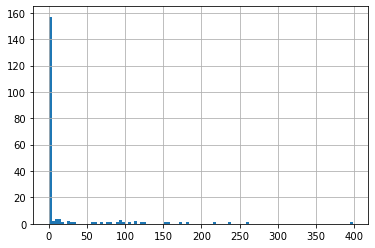

In [28]:
sfb_agg['total_blt'].hist(bins=100)

<AxesSubplot:>

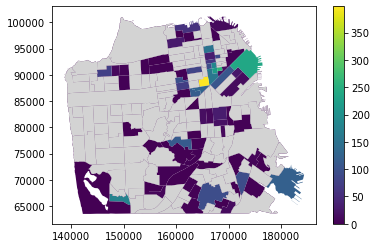

In [29]:
focus_col = 'total_blt'
ax = sfb_agg.plot(column = focus_col, legend=True, zorder=5)
sfb_agg[sfb_agg[focus_col]==0].plot(ax=ax, color='lightgrey', zorder=6)

## Pull from Census API

In [8]:
census_variables = {
    "2010_tot_pop": 'H010001'
}

sfblocks = censusdata.download(
    'sf1', # table
    2010,   # year
    censusdata.censusgeo([
        ('state', '06'),
        ('county', '075'),
        ('block group', '*')
        ]),
    list(census_variables.values())
    )

In [12]:
path = r"C:\Users\nelms\Documents\Penn\CPLN-680\Permit_Metrics\data\raw\georeference\tl_2010_06075_bg10.shp"
sfbg = gpd.read_file(path)